# Project Description

Use data collected from a Samsung health app to draw relevant conclusions.

#### Files:
+ [sleep-export2.csv](https://www.dropbox.com/s/7fdmc0l3410g8hu/sleep-export2.csv?dl=0)
+ [exercise.csv](https://www.dropbox.com/s/swvtjxw2ilcn4pl/exercise.csv?dl=0)
+ [heart_rate.csv](https://www.dropbox.com/s/7h2sphkvf4cjbsh/heart_rate.csv?dl=0)
+ [Step_Count](https://www.dropbox.com/s/4edk6mwwsb6dogp/step_co7unt.csv?dl=0)
+ [Floors_climbed](https://www.dropbox.com/s/wyde3yf57gurp1v/floors_climbed.csv?dl=0)

#### Jupyter Notebook:
+ Set up
  + Imports
  + Define Retrieve_Data class
  + Define relevant functions
+ Preprocess each data file individually
  + (Convert time labels to meaningful format. Create coarse features, such as: hour of the day, day of the week, time since timezone has changed, etc)
  + Pre-process: Sleep data
  + Pre-process: Exercise data
  + Pre-process: Step data
  + Pre-process: Heart data
  + Pre-process: Floors data
+ Overlapping Time:
  + Create a plot showing the range in time of each dataset. Include timzone changes and holidays
+ Analyze individual files
  + Sleep: Corner plot
  + Sleep: Sleep hour vs day of the week
  + Exercise: K-means analysis fo types of walking
  + Exercise: Corner plot
  + Step: Corner plot
  + Heart: Corner plot
  + Floors: Corner plot
+ Analyses: Combined data
  + Typical routine
  + One day snapshot
  + Exercise and heart data
+ Conclusions
+ Future work

#### Samsung app documentation:
+ [Technical details](https://developer.samsung.com/html/techdoc/ProgrammingGuide_SHealthService.pdf)
+ [Property description](https://developer.samsung.com/onlinedocs/health/index.html?com/samsung/android/sdk/healthdata/HealthConstants.Sleep.html)
+ [Health data](https://developer.samsung.com/onlinedocs/health/index.html?com/samsung/android/sdk/healthdata/HealthConstants.html)

#### Notes:
+ The reported times are all measured at the UTC timezone. They are corrected for the local time for these analyses. (See Field Detail - START_TIME in the app [documentation](https://developer.samsung.com/onlinedocs/health/index.html?com/samsung/android/sdk/healthdata/HealthConstants.Sleep.html).
+ A floor is 3m.
+ Units are as typical and in international units.

#### Dependencies:
+ Python 3.7 and general packages.
  + conda create -n py37 -c anaconda python=3.7
+ Holidays library.
  + conda install -c conda-forge holidays 


---
# Set up
+ Imports
+ Define Retrieve_Data class
+ Define Merge_Data class
---

#### Imports

In [84]:
import sys
import os
import calendar
import importlib
import pytz
import holidays
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator
from datetime import datetime
from datetime import timedelta
from dateutil import tz
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans

%matplotlib inline

#Set matplotlib variables for prettier plots.
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
fs = 20.

#Set seaborn fontsize and line width.
sns.set_context('notebook', font_scale=1.5, rc={'lines.linewidth': 2.5})

#### Process_Time

In [146]:
class Process_Time(object):
    """
    Description:
    ------------
    Given a list of time strings, convert it to a datetime object which is in the
    local timezone.
    """        
    def __init__(self, df, timestart_key, timeend_key, UTC_key, need_correction, time_format):
        self.df = df
        self.timestart_key = timestart_key
        self.timeend_key = timeend_key
        self.UTC_key = UTC_key
        self.need_correction = need_correction
        self.time_format = time_format
                        
    def create_date_obj(self, key):
        if self.time_format == 'milisec':
            time_obj = np.array(
              [datetime.fromtimestamp(t) for t in self.df[key].values/1000.])            
        else:
            time_obj = np.array(
              [datetime.strptime(t, self.time_format) for t in self.df[key].values])

        #Convert to local time if needed.
        if self.need_correction:
            from_zone = tz.gettz('UTC')
            to_zone = [tz.gettz(t_off) for t_off in self.df[self.UTC_key]]
            time_obj_corr = np.array([_t.replace(tzinfo=from_zone).astimezone(_to_zone).replace(tzinfo=None)
                                      for (_t,_to_zone) in zip(time_obj,to_zone)])            
        else:
            time_obj_corr = time_obj
            
        return time_obj_corr
    
    def run(self):
        #Compute start and end time in standard format.
        if self.timestart_key is not None:
            time_obj = self.create_date_obj(self.timestart_key)
            self.df['Start_time_obj'] = time_obj
            self.df['date'] = np.array([t.strftime('%Y/%m/%d') for t in time_obj]) 
            self.df['start_hour'] = np.array([t.hour + t.minute/60. + t.second/3600. for t in time_obj])  
            self.df['is_holiday'] = [t in holidays_list_str for t in self.df['date'].values]
            self.df['weekday'] = np.array([calendar.day_name[t.weekday()] for t in time_obj])
            sleep_df['weekday_num'] = sleep_df['weekday'].map(weekday_str2num)
    
        if self.timeend_key is not None:
            time_obj = self.create_date_obj(self.timeend_key)
            self.df['End_time_obj'] = time_obj        
            self.df['end_hour'] = np.array([t.hour + t.minute/60. + t.second/3600. for t in time_obj])
            
        if ((self.timestart_key is not None) and (self.timeend_key is not None)):
            self.df['dur'] = self.df['End_time_obj'] - self.df['Start_time_obj']

        #Sort df after all quantities have been computed.
        self.df.sort_values(by ='Start_time_obj', inplace=True)
        return self.df     

#### Functions

In [3]:
#Get quantiles
def get_quantiles(var_name, inp_array):
    """Get quantiles of a given array. Print median
    and 1-sigma interval. 
    """
    q = np.quantile(inp_array, np.array([0.16,0.5,0.84]))
    print('median of %s is %.2f with an 86%% interval of (%.2f,%.2f)' %(var_name, q[1], q[0], q[2]))
    
def add_tz_change(ax, time_obj, tz_list, add_text=True):
    """Given a plot axis as a function of time, add vertical lines on the dates when the timezone changed."""
    p = 0.5
    for t, tz in zip(time_obj, tz_list):
        ax.axvline(t, ls=':', lw=2, color='grey')
        if add_text:
            ax.text(t, p, tz, fontsize=10.)
        p += 0.2

def is_workday(is_holiday, weekday_num):
    if ((is_holiday) | (weekday_num==1) | (weekday_num==7)):
        return 0
    else:
        return 1
    

In [4]:
weekday_str2num = {'Sunday':1, 'Monday':2, 'Tuesday':3, 'Wednesday':4,
                   'Thursday':5, 'Friday':6, 'Saturday':7}

#https://developer.samsung.com/onlinedocs/health/EXERCISE_TYPE.html
exertype_num2str = {1001:'Walking', 0:'Custom', 14001:'Swimming',
                    1002:'Running', 11007:'Cycling', 13001:'Hiking',
                    15006:'Elliptical'}


#### Utilities

In [5]:
#These are global parameters to be used elsewhere.

t_initial = datetime(2016,5,1)
t_final = datetime(2018,10,1)

#List of days when the timezone changed in the relevant date range.
timezone = pytz.timezone("Canada/Eastern")
daylight_list = [t for t in timezone._utc_transition_times
             if ((t >  t_initial) & (t <  t_final))]

#list of holidays in the relevant time range.
holidays_obj = holidays.CountryHoliday('Canada', state=None, prov='Ontario')
holidays_list = holidays_obj[t_initial:t_final] 
holidays_list_str = [t.strftime('%Y/%m/%d') for t in holidays_list]

---
# Inspect Data
---

In [134]:
fpath = './data/sleep.csv'
sleep_df = pd.read_csv(fpath, header=0, index_col=0, low_memory=False)

#Rename columns for simplicity.
newcols = {col : col.replace('com.samsung.health.sleep.', '') for col in sleep_df.columns}
sleep_df.rename(columns=newcols, inplace=True) 

sl1u_df = Process_Time(sleep_df, 'start_time', 'end_time', 'time_offset', True, 'milisec').run()

In [138]:
fpath = './data/sleep_data.csv'
sleep2_df = pd.read_csv(fpath, header=0, index_col=0, low_memory=False)
sl2u_df = Process_Time(sleep2_df, 'start_time', None, 'time_offset', False, '%Y-%m-%d %H:%M:%S.%f').run()

In [153]:
fpath = './data/stress.csv'
stress_df = pd.read_csv(fpath, header=0, index_col=0, low_memory=False)
stress_df.dropna(subset=['start_time', 'end_time'], inplace=True)
stru_df = Process_Time(stress_df, 'start_time', 'end_time', 'time_offset', False, '%Y-%m-%d %H:%M:%S.%f').run()

In [80]:
fpath = './data/Exercise.csv'
exer_df = pd.read_csv(fpath, header=0, index_col=0, low_memory=False)
exu_df = Process_Time(exer_df, 'start_time', 'end_time', 'time_offset', False, '%Y-%m-%d %H:%M:%S.%f').run()

In [141]:
fpath = './data/step_count.csv'
step1_df = pd.read_csv(fpath, header=0, index_col=0, low_memory=False)
st1u_df = Process_Time(step1_df, 'start_time', 'end_time', 'time_offset', False, '%Y-%m-%d %H:%M:%S.%f').run()

In [140]:
fpath = './data/step_daily_trend.csv'
step2_df = pd.read_csv(fpath, header=0, index_col=0, low_memory=False)
st2u_df = Process_Time(step2_df, 'day_time', None, None, False, 'milisec').run()

In [92]:
fpath = './data/heart_rate.csv'
heart_df = pd.read_csv(fpath, header=0, index_col=0, low_memory=False)
hru_df = Process_Time(heart_df, 'start_time', 'end_time', 'time_offset', False, '%Y-%m-%d %H:%M:%S.%f').run()
hru_df = hru_df.iloc[2:,:] #Do not include first two rows. They date back to 1970.

In [83]:
fpath = './data/floors_climbed.csv'
floor_df = pd.read_csv(fpath, header=0, index_col=0, low_memory=False)
flu_df = Process_Time(floor_df, 'start_time', 'end_time', 'time_offset', False, '%Y-%m-%d %H:%M:%S.%f').run()

In [129]:
#Notes: day_time is prior to create_time. It suggests that this is day-wise data and day_time should be used.
fpath = './data/calories_burned.csv'
cal_df = pd.read_csv(fpath, header=0, index_col=0, low_memory=False)
cbu_df = Process_Time(cal_df, 'day_time', None, None, False, 'milisec').run()

In [130]:
fpath = './data/day_summary.csv'
ds_df = pd.read_csv(fpath, header=0, index_col=0, low_memory=False)
dsu_df = Process_Time(ds_df, 'day_time', None, None, False, 'milisec').run()

---
# Timeline Plot
---

<Figure size 432x288 with 0 Axes>

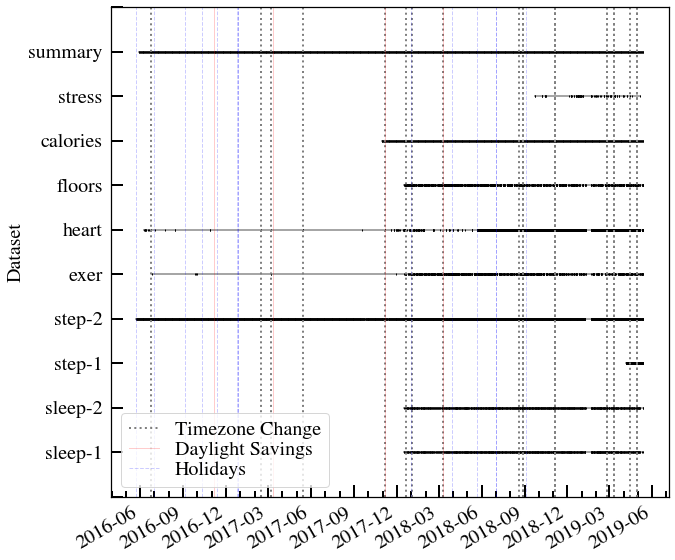

In [158]:
list_df = [sl1u_df, sl2u_df, st1u_df, st2u_df, exu_df, hru_df, flu_df, cbu_df, stru_df, dsu_df]
list_suffix = ['sleep-1', 'sleep-2', 'step-1', 'step-2', 'exer', 'heart', 'floors', 'calories', 'stress', 'summary']

def make_tz_changers(df):
    df.sort_values(by ='time', inplace=True)
    tz_list = df['tz'].values
    time_obj = df['time'].values
    cond = tz_list[:-1] != tz_list[1:]
    tz_changers = {}
    tz_changers['time_obj'] = time_obj[1:][cond]
    tz_changers['tz'] = tz_list[1:][cond]
    return pd.DataFrame(tz_changers)    

#Set Figure frame.
plt.clf()
fig, ax = plt.subplots(1,1, figsize=(10,10))

x_label = r'Time'
y_label = r'Dataset'
ax.set_xlabel('', fontsize=fs)
ax.set_ylabel(y_label, fontsize=fs)
ax.set_ylim(0., len(list_df) + 1.)
ax.tick_params(axis='y', which='major', labelsize=fs, pad=8)      
ax.tick_params(axis='x', which='major', labelsize=fs, pad=8)
ax.tick_params(
  'both', length=12, width=2., which='major', direction='in')
ax.tick_params(
  'both', length=6, width=2., which='minor', direction='in')    
ax.yaxis.set_major_locator(MultipleLocator(1.)) 


complete_tz, complete_t = [], []
for i, df in enumerate(list_df):
    time_obj = df['Start_time_obj'].values
    x = [min(time_obj), max(time_obj)]
    y = [i + 1, i + 1]
    ax.plot(x, y, marker='None', ls='-', lw=2., color='grey', alpha=0.7)
    ax.plot(time_obj, (i + 1) * np.ones(len(time_obj)), ls='None', marker='|', markersize=2., color='k')
    if 'time_offset' in df.columns:
        complete_t += list(time_obj)
        complete_tz += list(df['time_offset'].values)
ax.set_yticklabels(['', ''] + list_suffix)

#Add vertical lines where timezone has changed.
#use a compile list containing all time objects and their respective timezones.
aux_df = pd.DataFrame({'time':complete_t, 'tz':complete_tz})

tz_changers = make_tz_changers(aux_df) 
add_tz_change(ax, tz_changers['time_obj'], tz_changers['tz'], False)

#Add vertical lines for daylight saving changes.
for t in daylight_list:
    ax.axvline(t, ls='-', lw=1, alpha=.2, color='red')

#Add vertical lines for holidays
for t in holidays_list:
    ax.axvline(t, ls='--', lw=1, alpha=.2, color='blue')

#Make legend.
ax.plot([np.nan], [np.nan], ls=':', lw=2, color='grey', label='Timezone Change')
ax.plot([np.nan], [np.nan], ls='-', lw=1, alpha=.2, color='red', label='Daylight Savings')
ax.plot([np.nan], [np.nan], ls='--', lw=1, alpha=.2, color='blue', label='Holidays')

ax.legend(frameon=True, fontsize=fs, labelspacing=.1, numpoints=1, loc=3, handlelength=1.5)
    
#ax.xaxis.set_minor_locator(mdates.WeekdayLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
fig.autofmt_xdate()

---
# Analysis: Individual files
---

## Sleep: Corner Plot

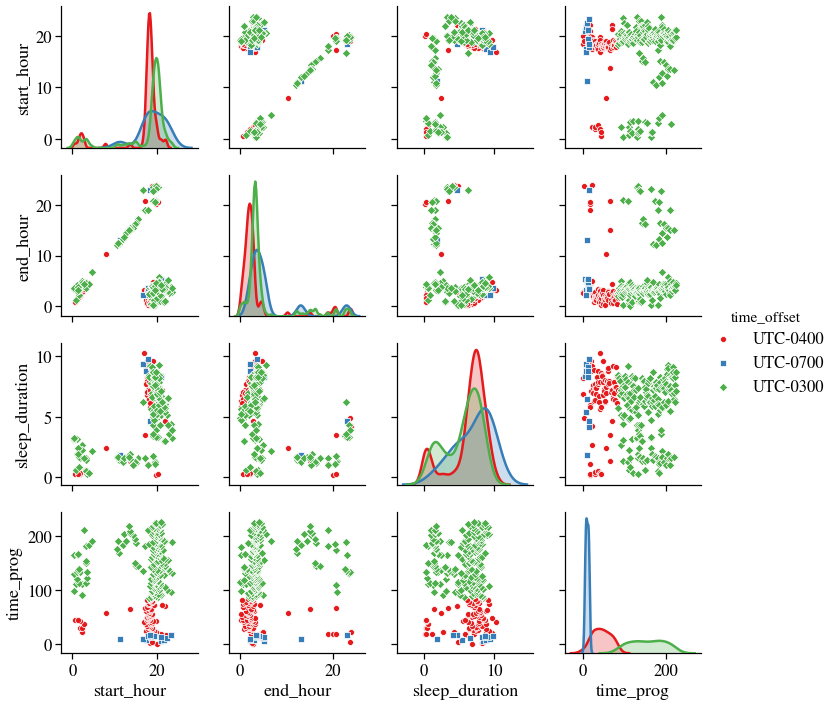

In [22]:
palette = ['#e41a1c','#377eb8','#4daf4a'] #From colorbrewer
pair_cols = ['start_hour', 'end_hour', 'sleep_duration', 'time_prog', 'time_offset']
g = sns.pairplot(sleep_df[pair_cols], hue='time_offset', markers=["o", "s", "D"],
                 palette=palette)

In [23]:
#palette = ['#e41a1c','#377eb8','#4daf4a'] #From colorbrewer
#pair_cols = ['start_hour', 'end_hour', 'sleep_duration', 'time_prog', 'tz_duration']
#g = sns.pairplot(sleep_df[pair_cols], hue='tz_duration', markers=["o", "s", "D"],
#                 palette=palette)

## Sleep: Bedtime (hour of the day) vs day of the week

median of Bedtime is 19.25 with an 86% interval of (15.01,20.71)
median of Wake-up time is 3.22 with an 86% interval of (1.92,5.03)


<Figure size 432x288 with 0 Axes>

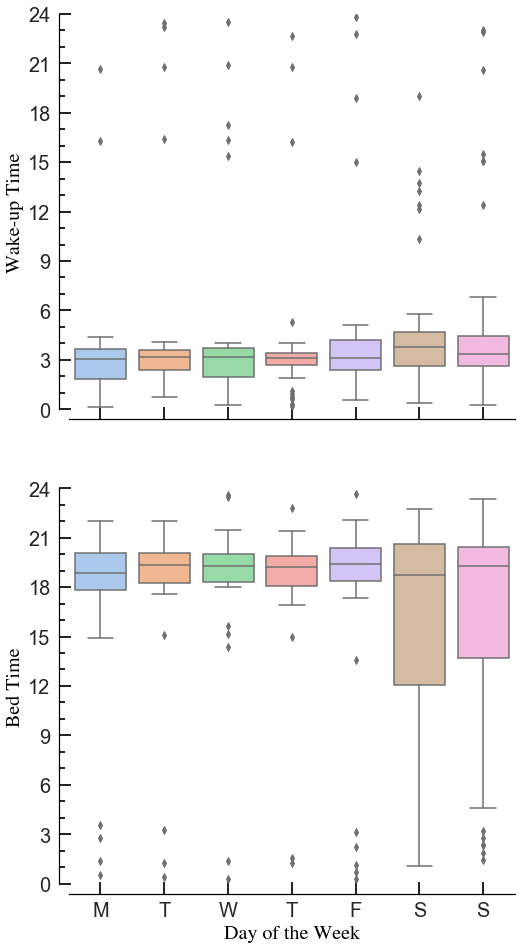

In [24]:
#Trim data by removing recent timezone changes.
aux_df = sleep_df[sleep_df['tz_duration'] == 'tz > 5']

#Make plots.
plt.clf()
fig, (ax1, ax2) = plt.subplots(
  2,1, gridspec_kw = {'height_ratios':[1, 1]}, figsize=(8,16))

sns.set(style='ticks', palette='pastel')
order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

g = sns.boxplot(x='weekday', y='end_hour', data=aux_df, ax=ax1, order=order)

g = sns.boxplot(x='weekday', y='start_hour', data=aux_df, ax=ax2, order=order)
g.set_xticklabels(['M', 'T', 'W', 'T', 'F', 'S', 'S'])

sns.despine(offset=10, trim=False)

y_label = r'Wake-up Time'
ax1.set_xlabel('', fontsize=fs)
ax1.set_ylabel(y_label, fontsize=fs)
ax1.set_ylim(0., 24.)
ax1.tick_params(axis='y', which='major', labelsize=fs, pad=8)      
ax1.tick_params(axis='x', which='major', labelsize=fs, pad=8)
ax1.tick_params(
  'both', length=12, width=2., which='major', direction='in')
ax1.tick_params(
  'both', length=6, width=2., which='minor', direction='in')    
ax1.yaxis.set_minor_locator(MultipleLocator(1.))
ax1.yaxis.set_major_locator(MultipleLocator(3.)) 
ax1.tick_params(labelbottom=False)  

x_label = r'Day of the Week'
y_label = r'Bed Time'
ax2.set_xlabel(x_label, fontsize=fs)
ax2.set_ylabel(y_label, fontsize=fs)
ax2.set_ylim(0., 24.)
ax2.tick_params(axis='y', which='major', labelsize=fs, pad=8)      
ax2.tick_params(axis='x', which='major', labelsize=fs, pad=8)
ax2.tick_params(
  'both', length=12, width=2., which='major', direction='in')
ax2.tick_params(
  'both', length=6, width=2., which='minor', direction='in')    
ax2.yaxis.set_minor_locator(MultipleLocator(1.))
ax2.yaxis.set_major_locator(MultipleLocator(3.))  

get_quantiles('Bedtime', sleep_df['start_hour'].values)
get_quantiles('Wake-up time', sleep_df['end_hour'].values)

## Exercise: K means analysis of types of walking

The Walking category in the exercise data can be too broad. Here I attempt to break it into subcategories.

In [25]:
#Source: article by Cory Maklin.
#https://towardsdatascience.com/machine-learning-algorithms-part-9-k-means-example-in-python-f2ad05ed5203

aux_df = exer_df[exer_df['exercise']=='Walking']
cols = ['exer_duration', 'mean_speed', 'max_speed', 'distance']
aux_df = aux_df[cols]
aux_df = aux_df.dropna()

sc = StandardScaler() 
X = sc.fit_transform(aux_df) 

Text(0, 0.5, 'WCSS metric')

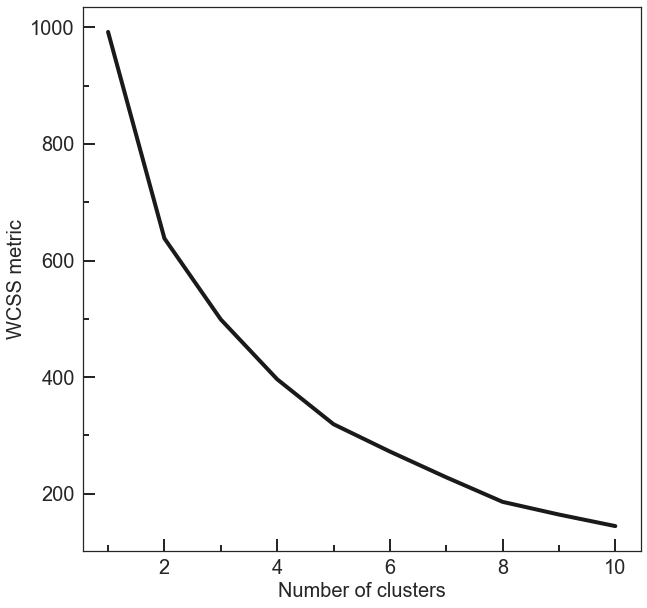

In [26]:
#Make a plot using the inertia derived for multiple choices of number of clusters.
#A knee will indicate the optimal number of clusters.

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

fig, ax = plt.subplots(1,1, figsize=(10,10))

ax.tick_params(axis='y', which='major', labelsize=fs, pad=8)      
ax.tick_params(axis='x', which='major', labelsize=fs, pad=8)
ax.tick_params('both', length=12, width=2., which='major', direction='in')
ax.tick_params('both', length=6, width=2., which='minor', direction='in') 
ax.xaxis.set_minor_locator(MultipleLocator(1.))
ax.xaxis.set_major_locator(MultipleLocator(2.))
ax.yaxis.set_minor_locator(MultipleLocator(100.))
ax.yaxis.set_major_locator(MultipleLocator(200.))

ax.plot(range(1, 11), wcss, ls='-', lw=4., color='k')
ax.set_xlabel('Number of clusters', fontsize=fs)
ax.set_ylabel('WCSS metric', fontsize=fs)

In [27]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(X)
aux_df['exercise_new'] = pred_y

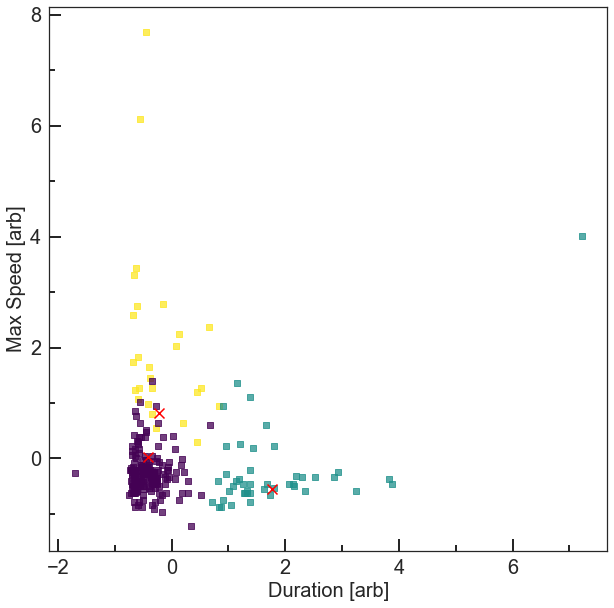

In [28]:
#Visualize gropuing in a 2D projection.

fig, ax = plt.subplots(1,1, figsize=(10,10))

ax.set_xlabel(r'Duration [arb]', fontsize=fs)
ax.set_ylabel(r'Max Speed [arb]', fontsize=fs)

ax.tick_params(axis='y', which='major', labelsize=fs, pad=8)      
ax.tick_params(axis='x', which='major', labelsize=fs, pad=8)
ax.tick_params('both', length=12, width=2., which='major', direction='in')
ax.tick_params('both', length=6, width=2., which='minor', direction='in') 
ax.xaxis.set_minor_locator(MultipleLocator(1.))
ax.xaxis.set_major_locator(MultipleLocator(2.))
ax.yaxis.set_minor_locator(MultipleLocator(1.))
ax.yaxis.set_major_locator(MultipleLocator(2.))

ax.scatter(X[:,0], X[:,2], c=pred_y, alpha=0.75, marker='s', cmap='viridis')
ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=100, c='red', marker='x')

In [29]:
#Merge the new types of exercising back into the original dataframe.
exer_df = pd.merge(exer_df, aux_df['exercise_new'], how='left', left_index=True, right_index=True)

In [30]:
cluster2str = {0:'Walking-1', 1:'Walking-2', 2:'Walking-3'}
def summarize_exercise_type(exer_label, exer_new):
    out = []
    for e_l, e_n in zip(exer_label, exer_new):
        if np.isnan(e_n):
            if e_l=='Walking':
                out.append('Walking_unknown')
            else:
                out.append(e_l)
        else:
            out.append(cluster2str[int(e_n)])
    return out

exer_df['exercise_up'] = summarize_exercise_type(exer_df['exercise'].values, exer_df['exercise_new'].values)

<Figure size 640x480 with 0 Axes>

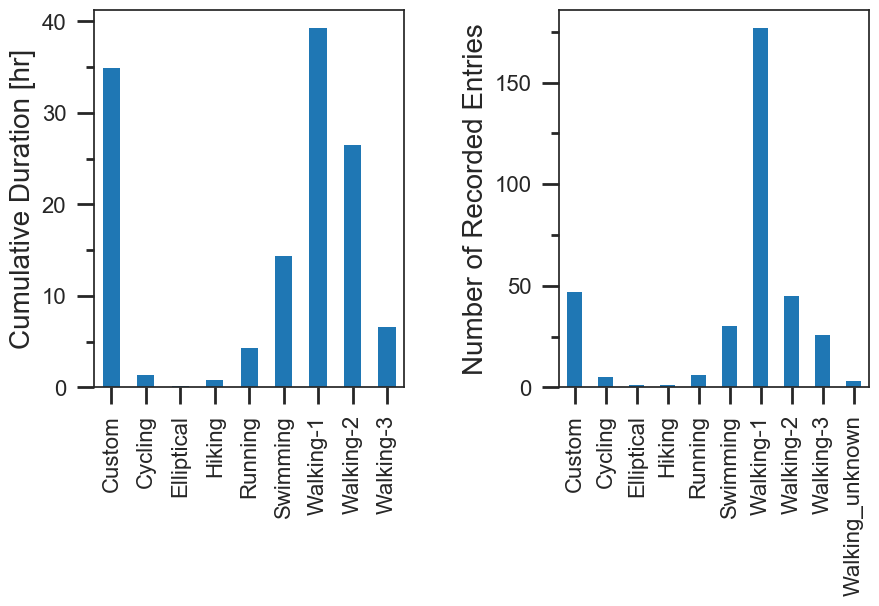

In [31]:
#Make plots.
importlib.reload(mpl); importlib.reload(plt)
plt.clf()

#initialize figure.
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
plt.subplots_adjust(wspace=.5)

aux_df = exer_df[exer_df['exercise_up'] != 'Walking_unknown']
aux_df = aux_df.groupby('exercise_up')['exer_duration'].sum()/60.
aux_df.plot(kind='bar', ax=ax1)

aux_df = exer_df.groupby('exercise_up')['exer_duration'].count()
aux_df.plot(kind='bar', ax=ax2)

ax1.set_xlabel('', fontsize=fs)
ax1.set_ylabel('Cumulative Duration [hr]', fontsize=fs)
ax1.tick_params(axis='y', which='major', labelsize=fs - 4., pad=8)      
ax1.tick_params(axis='x', which='major', labelsize=fs - 4., pad=8)
ax1.tick_params('both', length=12, width=2., which='major')
ax1.tick_params('both', length=6, width=2., which='minor') 
ax1.yaxis.set_minor_locator(MultipleLocator(5.))
ax1.yaxis.set_major_locator(MultipleLocator(10.))

ax2.set_xlabel('', fontsize=fs)
ax2.set_ylabel('Number of Recorded Entries', fontsize=fs)
ax2.tick_params(axis='y', which='major', labelsize=fs - 4., pad=8)      
ax2.tick_params(axis='x', which='major', labelsize=fs - 4., pad=8)
ax2.tick_params('both', length=12, width=2., which='major')
ax2.tick_params('both', length=6, width=2., which='minor') 
ax2.yaxis.set_minor_locator(MultipleLocator(25.))
ax2.yaxis.set_major_locator(MultipleLocator(50.))


## Exercise: Corner Plot

//anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
//anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


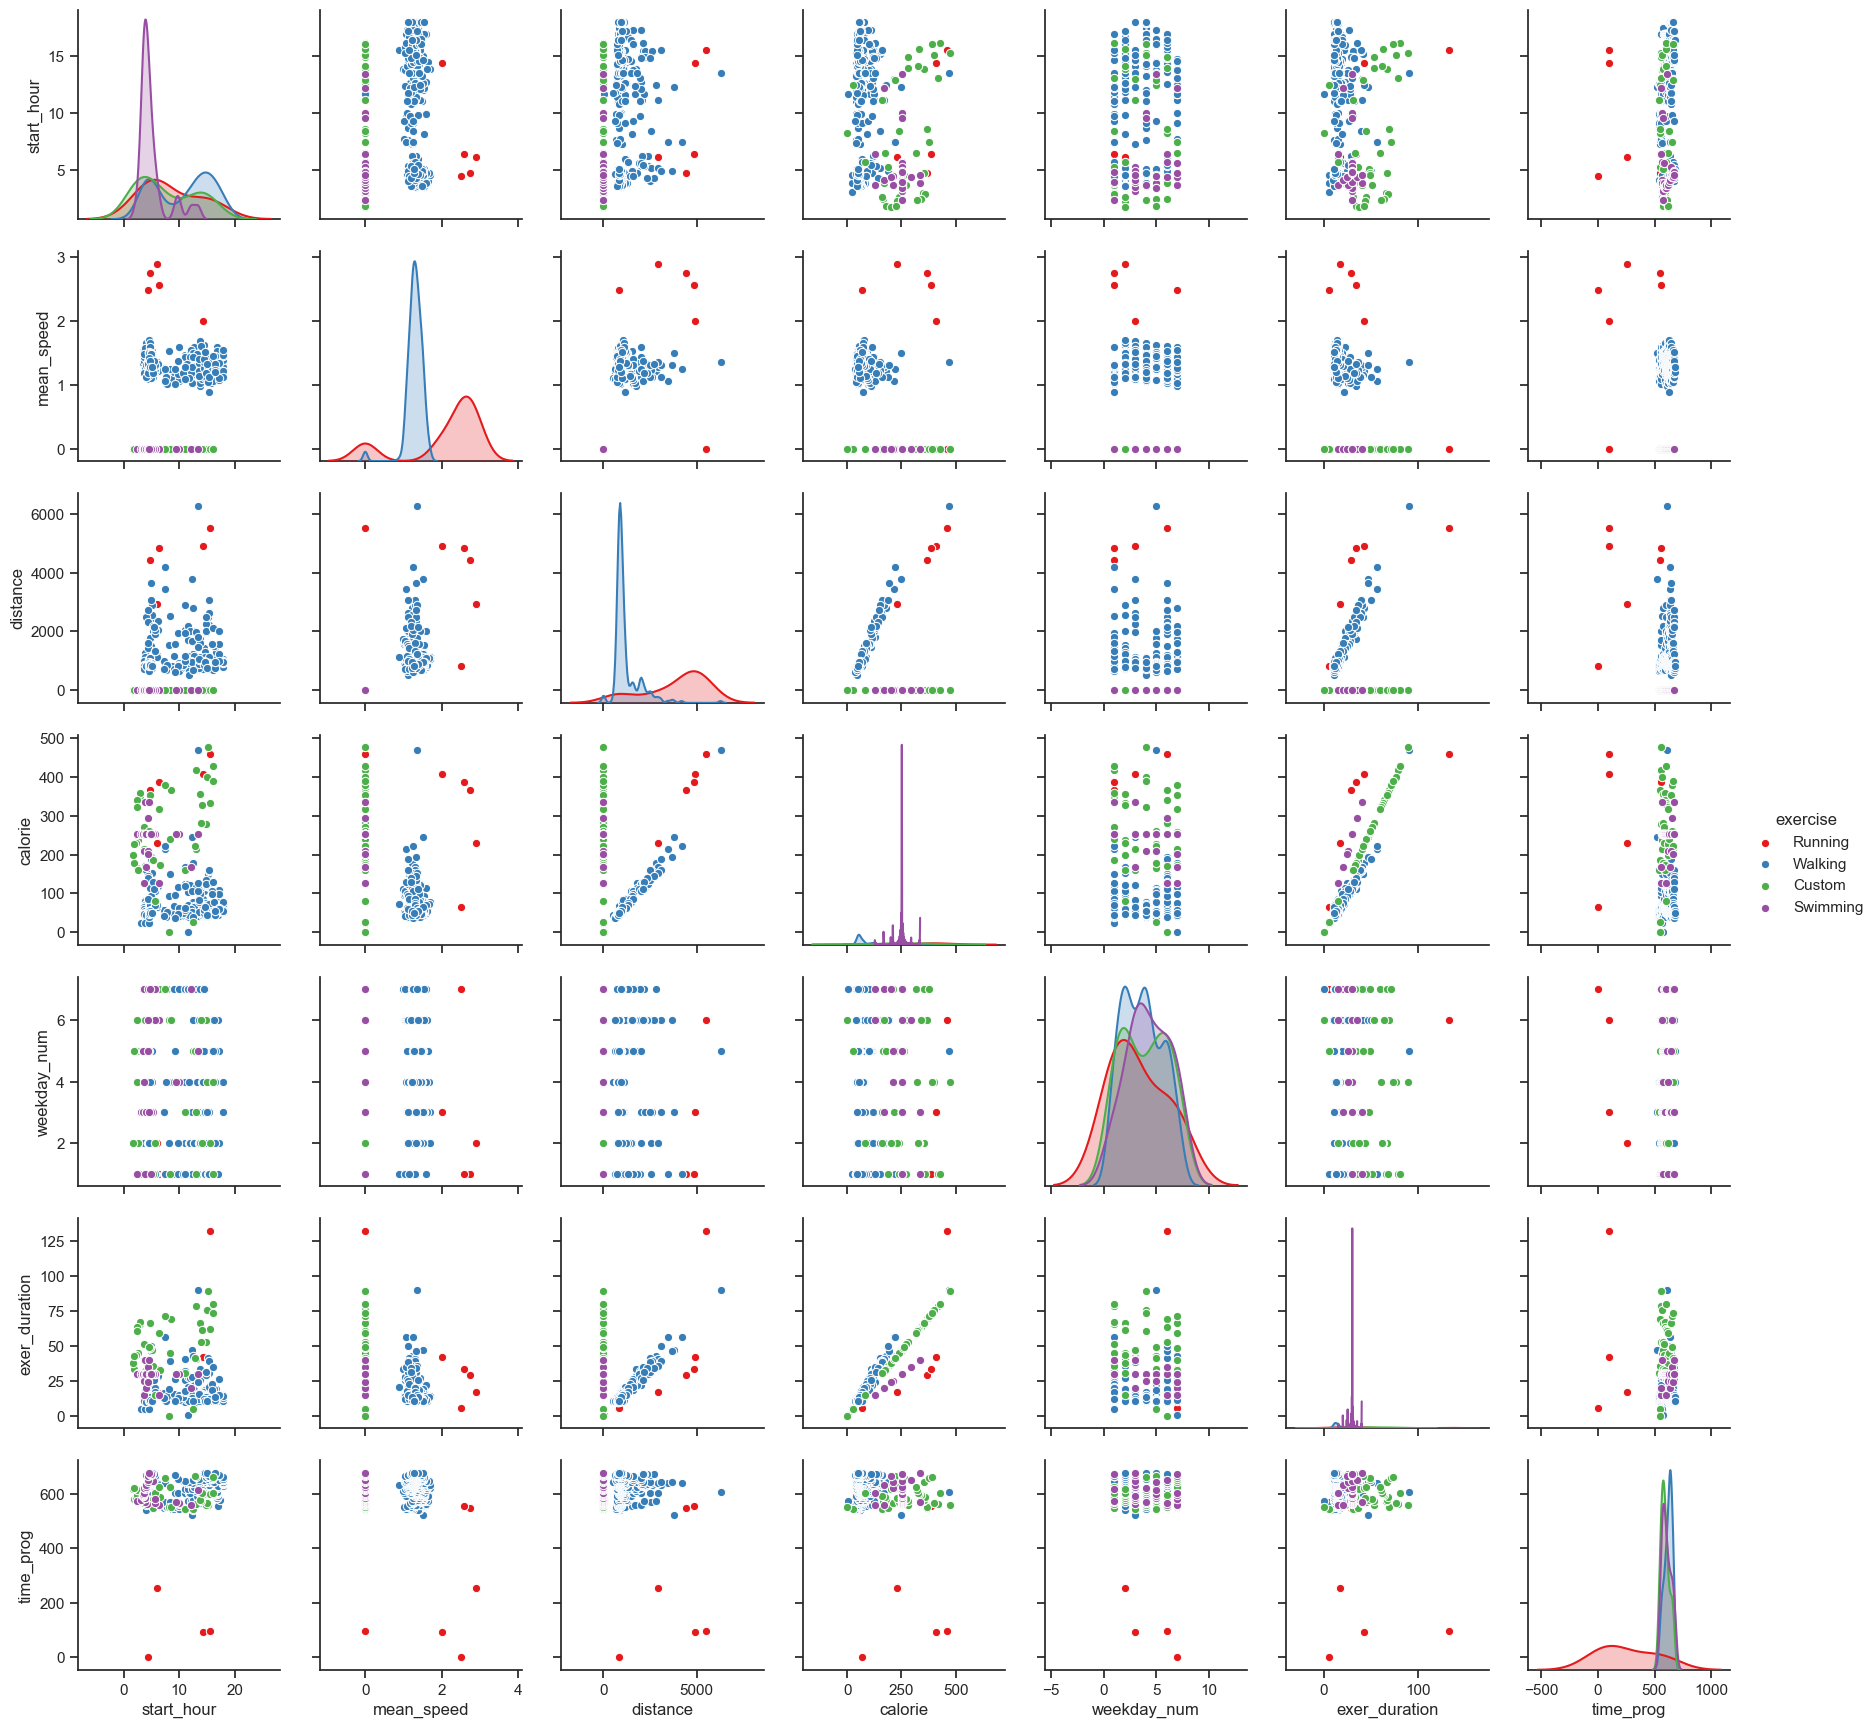

In [32]:
palette = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33'] #From colorbrewer
pair_cols = ['start_hour', 'mean_speed', 'distance', 'calorie',
             'weekday_num', 'exer_duration', 'exercise', 'time_prog']
aux_df = exer_df[pair_cols].dropna()

#Drop the two exercise types which have only one entry each.
aux_df.drop(aux_df[aux_df.exercise == 'Hiking'].index, inplace=True)
aux_df.drop(aux_df[aux_df.exercise == 'Cycling'].index, inplace=True)

g = sns.pairplot(aux_df[pair_cols], hue='exercise', palette=palette)

## Step: Corner plot

//anaconda3/envs/py37/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
//anaconda3/envs/py37/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


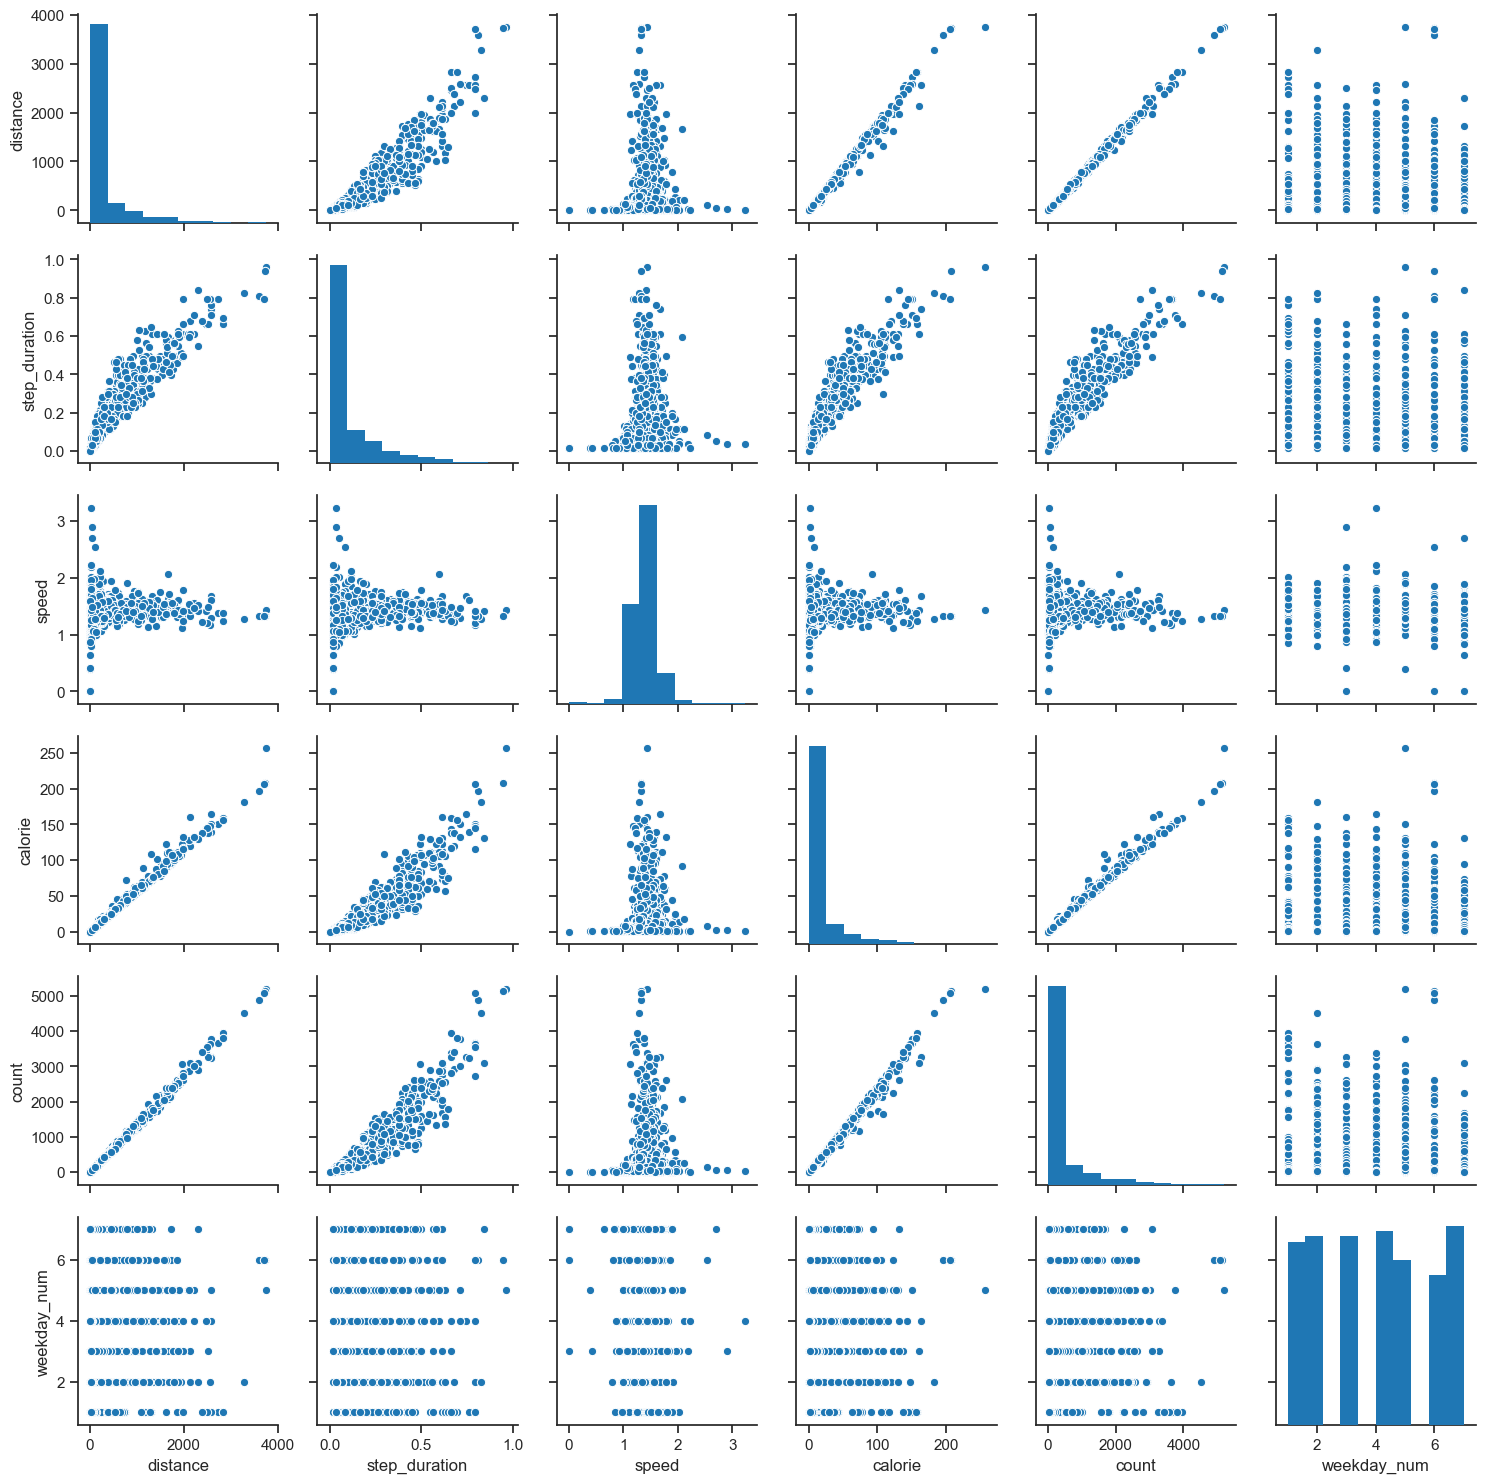

In [33]:
#Note, all entries are in the same timezone, UTC-0300
g = sns.pairplot(step_agg_df)

## Heart: Corner plot

Index(['end_time', 'heart_rate', 'binning_data', 'start_time',
       'heart_beat_count', 'update_time', 'max', 'min', 'pkg_name',
       'time_offset', 'datauuid', 'create_time', 'Start_time_obj',
       'End_time_obj', 'date', 'is_holiday', 'start_hour', 'weekday',
       'weekday_num', 'time_prog'],
      dtype='object')


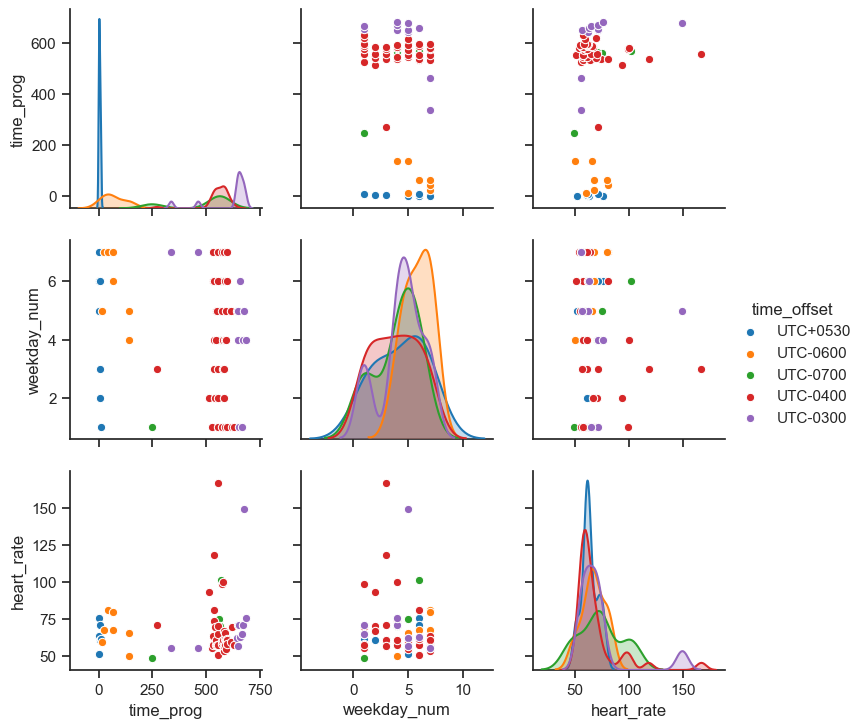

In [34]:
print(heart_df.columns)

pair_cols = ['time_prog', 'weekday_num', 'heart_rate', 'time_offset']
g = sns.pairplot(heart_agg_df[pair_cols], hue='time_offset')
#heart_df.describe()
#print(heart_agg_df)

In [35]:
get_quantiles('Heart rate', heart_df['heart_rate'].values)

median of Heart rate is 60.00 with an 86% interval of (52.00,72.00)


## Floors: Corner plot

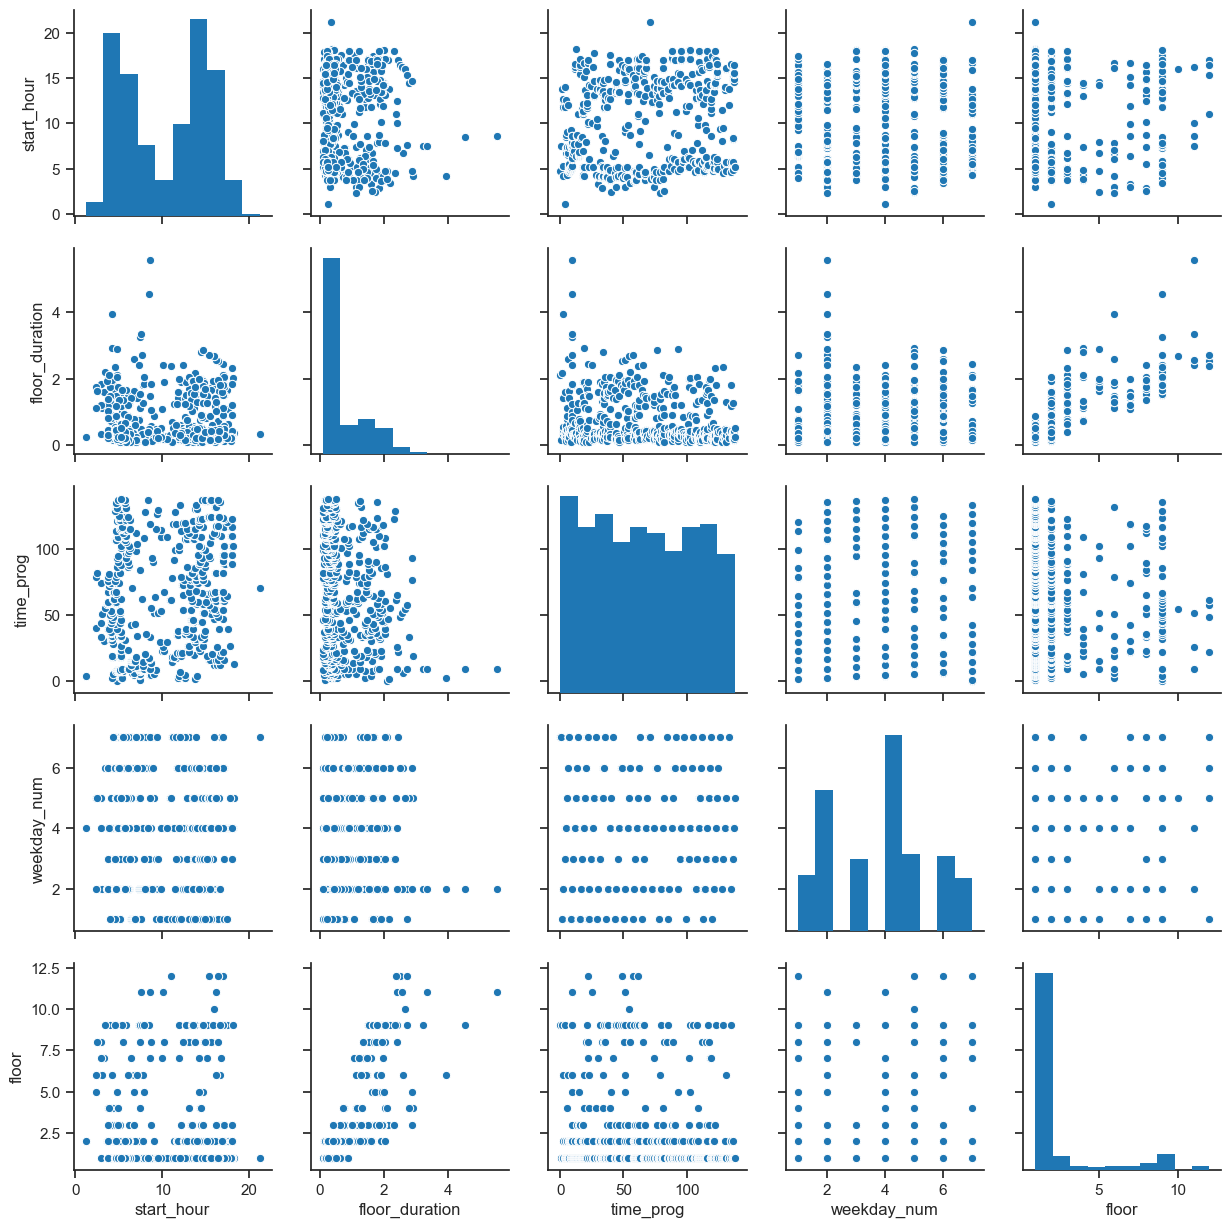

In [36]:
#Select relevant columns and make corner plot.
#aux_df = floor_df[floor_df['floor'] > 0.5]
#pair_cols = ['start_hour', 'floor_duration', 'time_prog', 'weekday_num']
#g = sns.pairplot(floor_df, vars=pair_cols, hue='floor_coarse')

pair_cols = ['start_hour', 'floor_duration', 'time_prog', 'weekday_num', 'floor']
g = sns.pairplot(floor_df, vars=pair_cols)

---
# Analysis: Combined data
---

## Typical routine

Use the period past 2018, when most datasets are available and there is no indication of vacation, to assess a this person's routine. Resample the data hourly and take the average of the integrated time period. Include only workdays.

<Figure size 640x480 with 0 Axes>

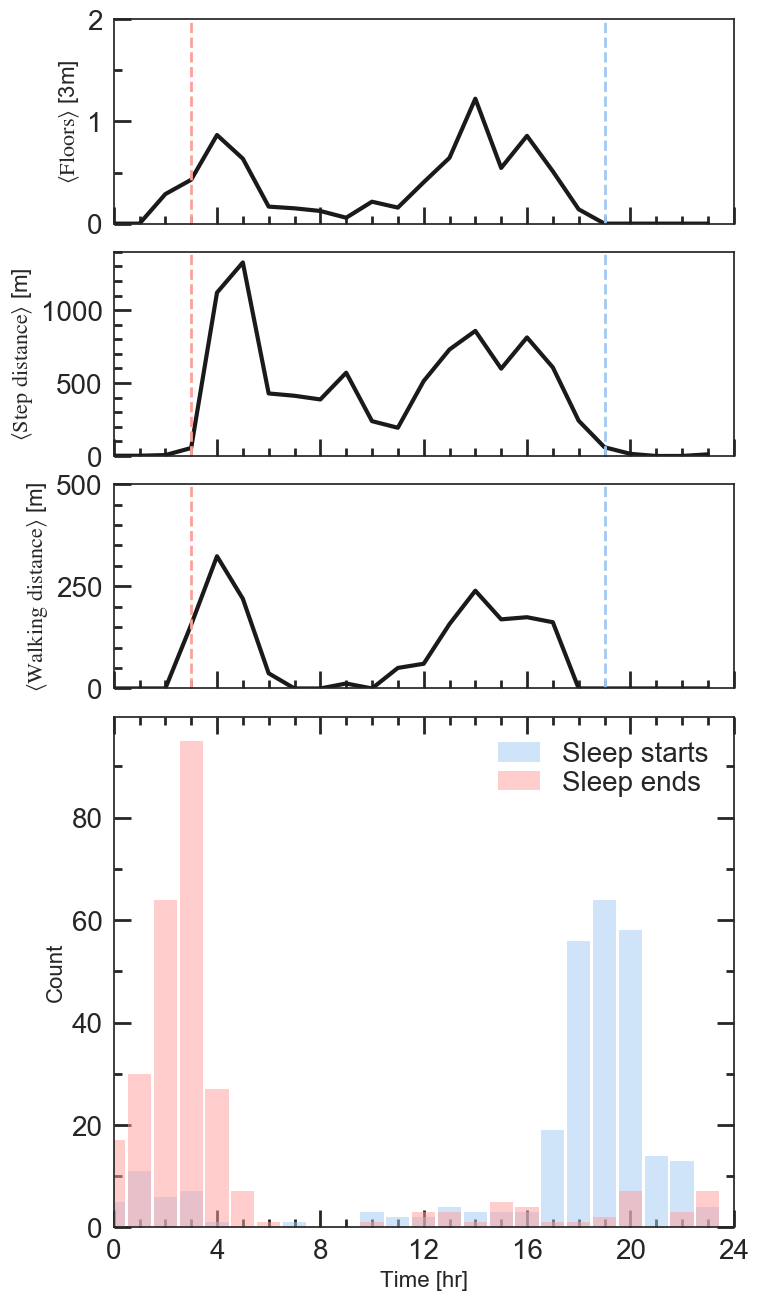

In [37]:
#The timezone difference in this subset happens at March 10th and is of
#1-hour. This is due to daylight saving hours changing.

def plot_hourly_mean(df, key, ax, p_args):
    P = '60T'
    t1 = pd.Timestamp('2018-01-01')
    
    
    #Simplify df.
    aux_df = df[['Start_time_obj', 'weekday_num', key]]
    cond = ((df['Start_time_obj'] > t1) & (df['weekday_num'] != 1)
            & (df['weekday_num'] != 7) & ~df['is_holiday'])
    aux_df = aux_df[cond]
    aux_df = aux_df.resample(P, on='Start_time_obj').agg({key:'sum'}).reset_index()
    aux_df['hour'] = aux_df['Start_time_obj'].dt.hour
    aux_df = aux_df.groupby(['hour'])
    aux_df = aux_df[key].mean().reset_index()
    #sns.lineplot(x='hour', y=key, data=aux_df, ax=ax)
    ax.plot(aux_df['hour'], aux_df[key], lw=3., color='k')

    #Treat subplot axis.
    ax.set_xlabel('', fontsize=fs)
    ax.set_ylabel(p_args[0], fontsize=fs - 4)
    ax.set_xlim(0., 24.)
    ax.set_ylim(p_args[1], p_args[2])
    ax.tick_params(axis='y', which='major', labelsize=fs, pad=8)      
    ax.tick_params(axis='x', which='major', labelsize=fs, pad=8)
    ax.tick_params(
      'both', length=12, width=2., which='major', direction='in')
    ax.tick_params(
      'both', length=6, width=2., which='minor', direction='in')    
    ax.xaxis.set_minor_locator(MultipleLocator(1.))
    ax.xaxis.set_major_locator(MultipleLocator(4.))
    ax.yaxis.set_minor_locator(MultipleLocator(p_args[3]))
    ax.yaxis.set_major_locator(MultipleLocator(p_args[4])) 
    ax.tick_params(labelbottom=False)  

    #Add vertical lines for typical wake-up and bed times.
    ax.axvline(x=wakeup, ls='--', color='r', lw=2.)
    ax.axvline(x=bedtime, ls='--', color='b', lw=2.)
    
#Make plots.
importlib.reload(mpl); importlib.reload(plt)
plt.clf()
fig, (ax1, ax2, ax3, ax4) = plt.subplots(
  4,1, gridspec_kw = {'height_ratios':[1, 1, 1, 2.5]}, figsize=(8,16))
plt.subplots_adjust(hspace=.1)

#Make histogram plot.
xlabel = r'Time [hr]'
ylabel = r'Count'
ax4.set_xlabel(xlabel, fontsize=fs - 4.)
ax4.set_ylabel(ylabel, fontsize=fs - 4.)
ax4.set_xlim(0., 24.)
ax4.tick_params(axis='y', which='major', labelsize=fs, pad=8)      
ax4.tick_params(axis='x', which='major', labelsize=fs, pad=8)
ax4.tick_params('both', length=12, width=2., which='major',
                     direction='in', right=True, top=True)
ax4.tick_params('both', length=6, width=2., which='minor',
                     direction='in', right=True, top=True) 
ax4.xaxis.set_minor_locator(MultipleLocator(1.))
ax4.xaxis.set_major_locator(MultipleLocator(4.))
ax4.yaxis.set_minor_locator(MultipleLocator(10.))
ax4.yaxis.set_major_locator(MultipleLocator(20.))

#Plot data.
ax4.hist(sleep_df['start_hour'], bins=np.arange(0,24.1,1), align='left',
         rwidth=0.9, color='b', alpha=0.5, label='Sleep starts')
ax4.hist(sleep_df['end_hour'], bins=np.arange(0,24.1,1), align='left',
         rwidth=0.9, color='r', alpha=0.5, label='Sleep ends')
ax4.legend(
  frameon=False, fontsize=fs, labelspacing=.1, numpoints=1, loc=1,
  handlelength=1.5)
wakeup = 3.
bedtime = 19.

#make additional plots.
walking_df = exer_df[exer_df['exercise'] == 'Walking']
#plot_hourly_mean(heart_df, 'heart_rate', ax1, [r'$\langle \mathrm{Heart rate} \rangle$ [m]', 0., 100., 10., 50.])
plot_hourly_mean(floor_df, 'floor', ax1, [r'$\langle \mathrm{Floors} \rangle$ [3m]', 0., 2., .5, 1.])
plot_hourly_mean(step_df, 'distance', ax2, [r'$\langle \mathrm{Step\ distance} \rangle$ [m]', 0., 1400., 100., 500.])
plot_hourly_mean(walking_df, 'distance', ax3, [r'$\langle \mathrm{Walking\ distance} \rangle$ [m]', 0., 500., 50., 250.])
#plot_hourly_mean(step_df, 'count', ax3, [r'$\langle \mathrm{Step} \rangle$ [m]', 0., 2000., 250, 1000.])
           


## One day snapshot

Use data from Apr 2018, when all dataframes are available, to build the snapshot of a work day. This should give more precise information on distances and timings. Using the timeline information, 2018/04/19 is an optimal date and is a Thursday.

<Figure size 640x480 with 0 Axes>

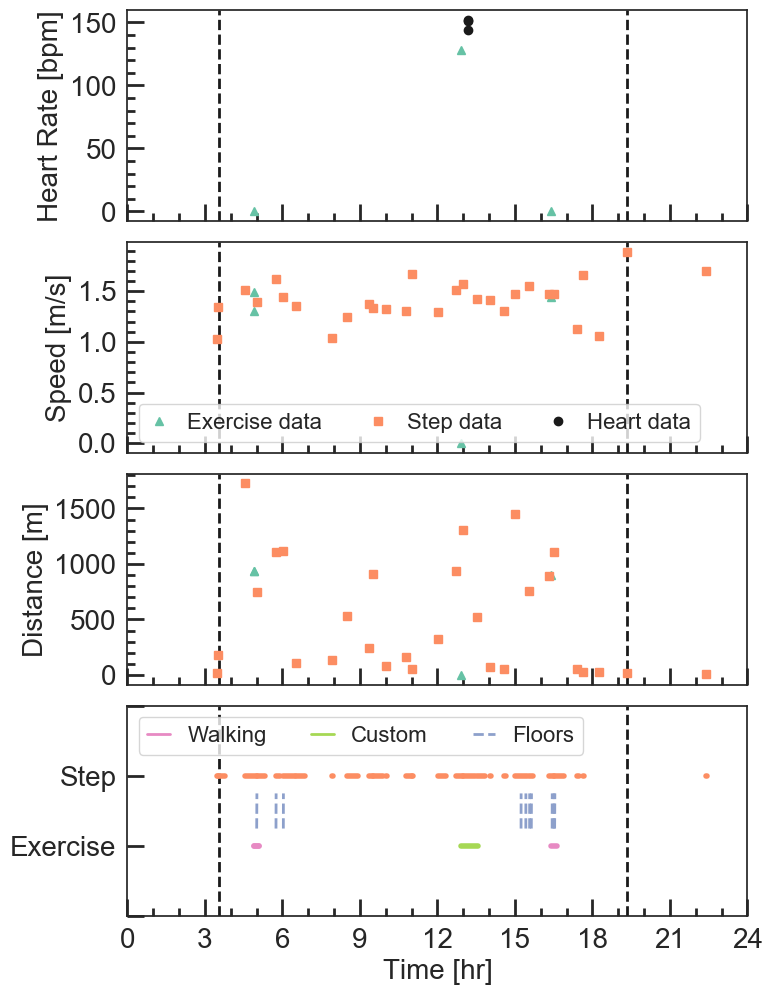

In [38]:
def get_duration(start, end):
    out_start = start.hour + start.minute/60. + start.second/3600.
    out_end = end.hour + end.minute/60. + end.second/3600.
    return [out_start, out_end]

c = ['#66c2a5','#fc8d62','#8da0cb', '#e78ac3', '#a6d854', '#ffd92f']
exer2color = {'Walking':c[3], 'Custom':c[4], 'Swimming':c[5]}

target_date = '2018/04/19'
#target_date = '2018/04/11'

#Subselect dictionaries.
aux_sleep_df = sleep_df[sleep_df['date']==target_date]
aux_heart_df = heart_df[heart_df['date']==target_date]
aux_step_df = step_agg_df[step_agg_df['date']==target_date]
aux_floor_df = floor_df[floor_df['date']==target_date]
aux_exer_df = exer_df[exer_df['date']==target_date]

#Get wake-up and sleep time.
for index,row in aux_sleep_df.iterrows():
    wakeup, bedtime = get_duration(row.Start_time_obj, row.End_time_obj)

#Make plots.
importlib.reload(mpl); importlib.reload(plt)
plt.clf()

#initialize figure.
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(8,12))
plt.subplots_adjust(hspace=.1)

ax4.set_ylim(0., 3.)
ax4.set_yticklabels(['', 'Exercise', 'Step', ''])

for i, ax in enumerate([ax1, ax2, ax3, ax4]):
    ax.tick_params(axis='y', which='major', labelsize=fs, pad=8)      
    ax.tick_params(axis='x', which='major', labelsize=fs, pad=8)
    ax.tick_params('both', length=12, width=2., which='major', direction='in')
    ax.tick_params('both', length=6, width=2., which='minor', direction='in')    
    ax.set_xlim(0., 24.)
    ax.xaxis.set_minor_locator(MultipleLocator(1.))
    ax.xaxis.set_major_locator(MultipleLocator(3.))
    ax.axvline(x=wakeup, ls='--', color='k', lw=2.)
    ax.axvline(x=bedtime, ls='--', color='k', lw=2.)

    if i != 3:
        ax.tick_params(labelbottom=False)  

#print(aux_exer_df.columns)
#print(aux_step_df)
#print(aux_heart_df)

for index,row in aux_exer_df.iterrows():
    x = get_duration(row.Start_time_obj, row.End_time_obj)
    ax1.plot([x[0]], [row['mean_heart_rate']], ls='None', lw=4., marker='^', color=c[0])
    ax2.plot([x[0]], [row['altitude_gain']], ls='None', lw=4., marker='^', color=c[0])
    ax2.plot([x[0]], [row['mean_speed']], ls='None', lw=4., marker='^', color=c[0])
    ax3.plot([x[0]], [row['distance']], ls='None', lw=4., marker='^', color=c[0])
    ax4.plot(x, [1.,1.], ls='-', lw=4., marker='None', color=exer2color[row['exercise']])

for index,row in aux_step_df.iterrows():
    x = get_duration(row.Start_time_obj, row.End_time_obj)
    ax2.plot([x[0]], [row['speed']], ls='None', lw=4., marker='s', color=c[1])
    ax3.plot([x[0]], [row['distance']], ls='None', lw=4., marker='s', color=c[1])
    ax4.plot(x, [2.,2.], ls='-', lw=4., marker='None', color=c[1])

for index,row in aux_floor_df.iterrows():
    x = get_duration(row.Start_time_obj, row.End_time_obj)
    ax4.plot(x, [1.25,1.75], ls='--', lw=2., marker='None', color=c[2])

for index,row in aux_heart_df.iterrows():
    x = get_duration(row.Start_time_obj, row.End_time_obj)
    ax1.plot([x[0]], [row['heart_rate']], ls='None', lw=4., marker='o', color='k')
    
#Add labels.
ax1.set_ylabel(r'Heart Rate [bpm]', fontsize=fs)
ax2.set_ylabel(r'Speed [m/s]', fontsize=fs)
ax3.set_ylabel(r'Distance [m]', fontsize=fs)
ax4.set_xlabel(r'Time [hr]', fontsize=fs)

#Add ticks.
ax1.yaxis.set_minor_locator(MultipleLocator(10.))
ax1.yaxis.set_major_locator(MultipleLocator(50.))
ax2.yaxis.set_minor_locator(MultipleLocator(.1))
ax2.yaxis.set_major_locator(MultipleLocator(.5))
ax3.yaxis.set_minor_locator(MultipleLocator(100.))
ax3.yaxis.set_major_locator(MultipleLocator(500.))
    
#Add legends.
ax4.plot([np.nan], [np.nan], ls='-', lw=2, color=c[3], label='Walking')
ax4.plot([np.nan], [np.nan], ls='-', lw=2, color=c[4], label='Custom')
#ax4.plot([np.nan], [np.nan], ls='-', lw=2, color=c[5], label='Swimming')
ax4.plot([np.nan], [np.nan], ls='--', lw=2, color=c[2], label='Floors')
ax4.legend(frameon=True, fontsize=fs - 4., ncol=3, labelspacing=0., numpoints=1, loc=2, handlelength=1.)

ax2.plot([np.nan], [np.nan], ls='None', marker='^', color=c[0], label='Exercise data')
ax2.plot([np.nan], [np.nan], ls='None', marker='s', color=c[1], label='Step data')
ax2.plot([np.nan], [np.nan], ls='None', marker='o', color='k', label='Heart data')
ax2.legend(frameon=True, fontsize=fs - 4., ncol=3, labelspacing=0., numpoints=1, loc=3, handlelength=1.)


## Exercise and heart rate

I combined the exercise and heart rate data, but the latter is much more sporadic and less reliable than the sparse heart rate informtion embedded in the exercise dataset. Below, I look in detail into the exercise data.

In [39]:
#Merge data, temp.

P = '15T'

#Aggregate the data according to date.
aggregator = {'heart_rate':'mean'}
heart_agg_df = heart_df.resample(P, on='Start_time_obj').agg({'heart_rate':'mean'})
heart_agg_df = heart_agg_df.reset_index()
heart_agg_df = heart_agg_df.dropna(subset=['heart_rate'])

aggregator = {'exer_duration':'sum', 'altitude_gain':'sum', 'exercise_up':'first',
              'max_speed':'max', 'start_hour':'first'}
exer_agg_df = exer_df.resample(P, on='Start_time_obj').agg(aggregator)
exer_agg_df = exer_agg_df.reset_index()
aux_df = pd.merge(heart_agg_df, exer_agg_df, how='left', on='Start_time_obj')

<Figure size 640x480 with 0 Axes>

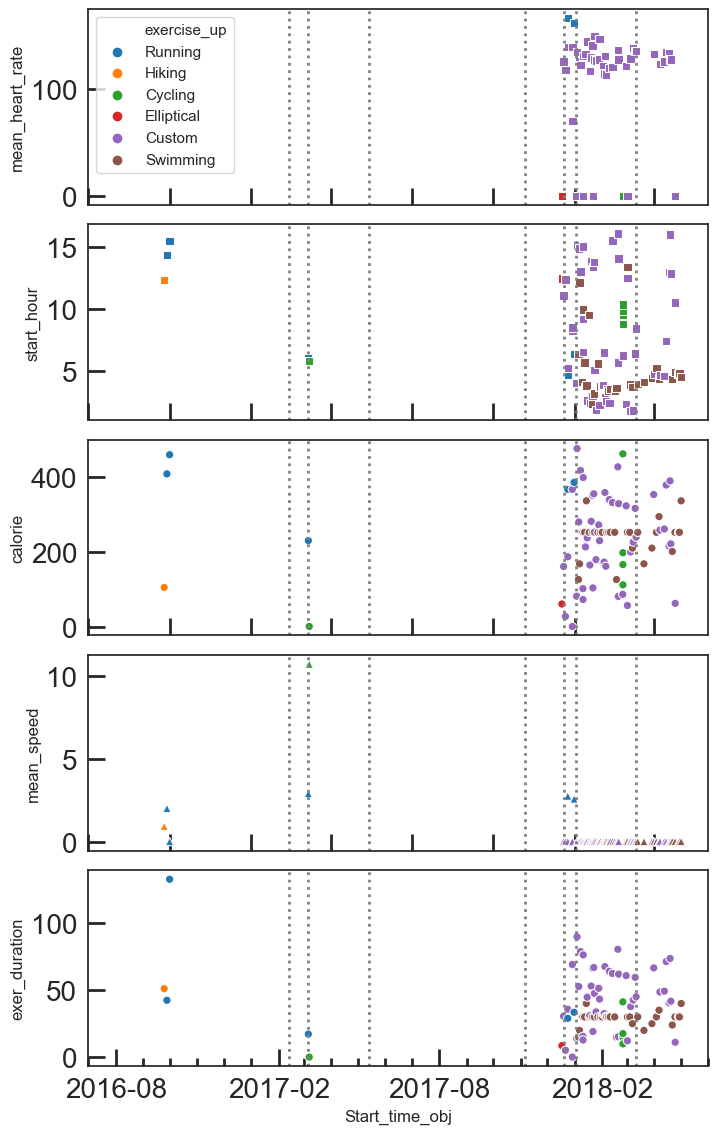

In [40]:
exer_df.describe(include='all')

cols = ['Start_time_obj', 'altitude_gain', 'mean_speed', 'distance', 'max_speed', 'calorie',
        'exer_duration', 'max_heart_rate', 'mean_heart_rate', 'exercise_up', 'start_hour']

#ti = datetime(2017,12,1)
ti = datetime(2016,7,1)
tf = datetime(2018,6,1)
tz_aux = tz_changers[((tz_changers['time_obj'] > ti) & (tz_changers['time_obj'] < tf))]

aux_df = exer_df[exer_df['exercise']!='Walking']

#Make plots.
importlib.reload(mpl); importlib.reload(plt)
plt.clf()

#initialize figure.
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,1, figsize=(8,14))
plt.subplots_adjust(hspace=.1)

for i, ax in enumerate([ax1, ax2, ax3, ax4, ax5]):
    ax.tick_params(axis='y', which='major', labelsize=fs, pad=8)      
    ax.tick_params(axis='x', which='major', labelsize=fs, pad=8)
    ax.tick_params('both', length=12, width=2., which='major', direction='in')
    ax.tick_params('both', length=6, width=2., which='minor', direction='in')    
    add_tz_change(ax, tz_aux['time_obj'], tz_aux['tz'], False)
    ax.set_xlim(ti, tf)
    
    if i != 4:
        ax.tick_params(labelbottom=False)  
    
#Add data points.
sns.scatterplot(x='Start_time_obj', y='mean_heart_rate', marker='s', hue='exercise_up', data=aux_df, ax=ax1)
sns.scatterplot(x='Start_time_obj', y='start_hour', marker='s', hue='exercise_up', data=aux_df, ax=ax2, legend=False)
sns.scatterplot(x='Start_time_obj', y='calorie', hue='exercise_up', data=aux_df, ax=ax3, legend=False)
sns.scatterplot(x='Start_time_obj', y='mean_speed', marker='^', hue='exercise_up', data=aux_df, ax=ax4, legend=False)
sns.scatterplot(x='Start_time_obj', y='exer_duration', hue='exercise_up', data=aux_df, ax=ax5, legend=False)

ax5.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
ax5.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
#fig.autofmt_xdate()    

---
# Conclusions
---

+ Overlapping time
  + There are two distinct timezone that are relevant:
    + UTC -4 (UTC -3 with DST).
    + UTC -7 (UTC -6 with DST).
    + UTC +5:30 (But only a few entries in the heart data only, this disregarded here.)
  + Assuming this person lives in Canada, the most likely locations are:
    + UTC -4: New Brunswick (NB), Nova Scotia (NS), Prince Edward Island (PE).
    + UTC -7: Alberta (AL), Northwest Territories (NT).
    + Note, the data has gaps, and therefore the recorded change in timzone due to dylight savings might not coincide with the actual DST change.
  + Likely scenario: **This person lived in Edmonton from July-2016 to April-2017**, when she/he **moved to Halifax for work**. In **Dec 2017, she/he went on vaction back to Edmonton for the Christmas holidays, suggestion family members living in Edmonton**.
  + I further speculate then that this person **is a young professional who moved away from the family home to work in Halifax**.
  + Given that Halifax economy is driven by **agriculture, fishing, natural gas and forestry** ([source](https://en.wikipedia.org/wiki/Economy_of_Halifax,_Nova_Scotia)), I speculate that this person's job is related to one of these fields. Military employment is another option.

+ Individual analyses
  + Sleep: Corner Plot
    + Typical sleep duration is ~8-9h, with the execption of a few naps that last ~1h.
    + Typical **bedtime is ~7-8pm** and typical **wake-up time is ~2-3am**.

  + Sleep: Bedtime (hour of the day) vs day of the week
    + On the days off (Saturday and Sunday--discussed below), she/he take naps during the day as well, making the bedtime distribution have a large variance.
    + On Saturdays, the bedtime can be as early as 3am (which is a typical wake-up time). Tihs may indicate the person sometimes **goes to late-hour parties**. This may further indicate a person in their **20's or 30's**, which agress with the idea of a young profesional.

  + Exercise: Types of Walk
    + I used a K-means analysis to try to identify different types of walking, which is a broad category in the exercise data.
    + I find no clear elbow in the wcss metric, which suggests that there is no obvious number of groups that will satisfactorily explain the data. I choose 3 groups as a compromise between having a small number of groups and a low wcss.
    + The three groups seem to be a broad split the mean speed and duration of the walking. Removing the duration from the analysis yielded no clear 'elbow' either.
    + Aside from walking, 'swimming' and 'custom' exercises were the prevalent ones both in counts and cumulative duration over the recorded period. As discussed below, the custom type may also correspond to swimming.

  + Exercise: Corner Plot
    + Not much movement during certain times of weekdays, which will be further explored below. Based on movement, work likely **starts at 6am, with a lunch around 10am, ending around 2pm**. Saturday and Sunday are the days off. Person often has to walk fast to get to work, or take transit.
    + Distance peaks around 1000m, which is the likely distance from home to work, or to a bus/subway station. Most likely this person **walks ~1km to work**.

  + Heart: Corner plot
    + **The typical heart rate is 60.50 with an 86% interval of (52.12,72.00)**.
      + If we believe this person to be younger than 40 (see above), then **this person is likely a woman**. This is because women tend to have a resting heart rate between 60 and 64 bpm, compared to 66 to 68 bpm for men (see [source](https://healthsolutions.fitbit.com/blog/resting-heart-rate/)).
    + The person has been slightly more active in recent times.

  + Floors: Corner plot
    + Floors climbed exhibit two spikes as a faunction of hour of the day, around 8am and 1pm. This is slightly after and  slightly before the estimated work time, which is intriguing. Perhaps the work schedule is shorter and there is some commute time to be considered. In any case, this indicates that the person **works on the second floor**. Some floor activity around noon corroborates the idea of sporadically going out for lunch.

+ Combined data
  + Typical routine
    + This analysis cements that: person wakes up around **3am**, likely has a breakfast and some exercising and **walks ~1km to work, arrving 5-6am**, typically moves 300m/hr during work hours, which suggests the she/he **does not have a desk job, nor a job the requires a lot of movement**. She/he sometimes goes out for **lunch around 12pm** and **leaves work 2-3pm**. There are typically **errands/exercise from 3 to 6pm**, coming back home and going to **sleep around 7pm**. 
  + One day snapshot
    + This shows in detail the heart rate, exercise, steps and sleep for a particular day that happens to have fairly complete data. The analysis supports the conclusions above, with the addition of:
    + The custom exercising starts at 1pm, possibly indicating **flexible work hours**.
  + Exercise and heart rate
     + For a more targeted investigation, this excludes walking data.
     + Swimming exercise is predominant, alongside a custom exercise. **Typical swimming hours are 4-5am, but sometimes after works hours (~3pm)**. **It burns ~200-400cal, lasts ~40-60min, and there is little displacement (low speed)**.
     + The custom exercise shows a similar pattern to the swimming exercise. **Possibly also corresponding to swimming**. This could be the case if the doesn't always start the app routine as swimming.
       + If correct, then this person likely has the patience to set the mode to swimming in the morning, but not after work, thus **suggesting tiredeness fom working, but also discipline to maintain the exercising routine**. Furthermore, **when using the swimming mode, the exercise duration is near the shorter end, indicating perhaps a target duration or caloric burning, possibly for weight loss**.
     + Conversely, another possibility for the custom exercise is a gym workout, which could exhibit similar patterns to swimming, explaining the duration, caloric burn and similar hours.
     + All considered, she/he **is likely a healthy individual, perhaps trying to lose weight**.

  + I speculate that this person **works in the food industry, perhaps as a prep cook or chef**, which would explain the early hours, the low/moderate number of steps and moving distance during work hours (as opposed to military and forestry jobs).  Another possibility is that she/he **works in the fishing or natural gas industries**, this comes from the most likely industries in Halifax, but the caveat here is that workers in these jobs are predominantly male, thus making this assessment less likely, albeit not to be discarded.


---
# Future work
---

Possible further analysis to the data would consist of:

+ Attempting to identify the marital status of the person. 